## RUL prediction using Support Vector Regression (SVR)

In this notebook, we will apply SVR to predict RUL of NASA's turbofan engine dataset FD001. We will use scikit-learn to implement SVR.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
pd.set_option('display.max_columns', None)

np.random.seed(324)

In [2]:
print("Numpy version: ", np.__version__)
print("Pandas version: ", pd.__version__)
print("Scikit-learn version: ", sklearn.__version__)

Numpy version:  1.24.2
Pandas version:  1.5.3
Scikit-learn version:  1.2.2


## Data Preprocessing

We strongly encourage readers to go through the [dataset description and prreprocessing notebook](https://github.com/biswajitsahoo1111/rul_codes_open/blob/master/notebooks/cmapss_notebooks/CMAPSS_data_description_and_preprocessing.ipynb). In that notebook we have explained how data preprocessing functions work with simple examples. In this notebook we will only use those functions. So prior familiarity with these functions is an advantage. 

We will calculate two prediction scores on test data. In one case, we will take last 5 examples of test data for engine, calculate their predictions, and finally average those for each engine. In the second case, we will take only the last example of each engine and make predictions. The logic behind taking last 5 examples and averaging their predictions is to make the prediction robust against outliers. Due to some external factor, if our last example happens to be corrupted, its prediction outcome might be far off from the actual one. But if we average predictions from last 5 examples, we will get a more conservative estimate. 

In the following cell we will show boxplots of each column of training data. That will give us an idea about the values in different columns. If all the values in a column are constant, we drop those columns from our analysis.

Readers can download the data from [here](https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#turbofan). In the following cells, wherever data are read from a folder, readers should change the string to point to the respective folder from their system to run this notebook seamlessly. 

In [3]:
train_data = pd.read_csv("train_FD001.txt", sep = "\s+", header = None)
train_data.shape

(20631, 26)

In [4]:
train_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


This dataset has 26 columns (In fact, all 4 training and test datasets have 26 columns). Because of Python's numbering convention, the columns are numbered from 0 to 25. Column 1 is numbered as 0, Column 2 is numbered as 1, and so on. Description of each column is as follows:

Column 1: Corresponds to engine number (This column is indexed 0 above because of Python's numbering convention)
Column 2: Corresponds to cycle number. If engine 1 fails after 192 cycles, the entries of second column for engine 1 will go from 1 to 192. Similarly for other engines.
Columns 3,4,5: 3 operational settings
Columns 6-26: 21 sensor measurements
Note: Henceforth, we will always refer to the first column as column 1 even though it is indexed as 0 in Python. Similarly for other columns.

So there are 100 engines. Our next goal is to find out how many cycles each engine took to failure.
### 
After how many cycles does each engine fail?

In [5]:
np.unique(train_data[0])

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100], dtype=int64)

In [6]:
# number of cycles for each model to fail
num_cycles_to_failure = train_data.groupby(0)[1].count()
num_cycles_to_failure.values

array([192, 287, 179, 189, 269, 188, 259, 150, 201, 222, 240, 170, 163,
       180, 207, 209, 276, 195, 158, 234, 195, 202, 168, 147, 230, 199,
       156, 165, 163, 194, 234, 191, 200, 195, 181, 158, 170, 194, 128,
       188, 216, 196, 207, 192, 158, 256, 214, 231, 215, 198, 213, 213,
       195, 257, 193, 275, 137, 147, 231, 172, 185, 180, 174, 283, 153,
       202, 313, 199, 362, 137, 208, 213, 213, 166, 229, 210, 154, 231,
       199, 185, 240, 214, 293, 267, 188, 278, 178, 213, 217, 154, 135,
       341, 155, 258, 283, 336, 202, 156, 185, 200], dtype=int64)

How to find training RUL values?
Observe that there is no RUL data provided for training set. Do we need that? In fact, we can calculate RUL values from training data itself. Remember that training data contains run to failure data of all engines.

Engine 1 fails after 192 cycles. So at the first cycle of engine 1, its RUL is 191. After cycle 2, its RUL is 190 and so on. As it fails after 192 cycles, at 192nd cycle, its RUL is 0. This type of degradation model is called linear degradation model. From the start of the cycle it decreases gradually to 0 at the last cycle.

Apart from linear degradation model, there is another degradation model called piecewise linear degradation model that is also widely used. In this model, at the beginning (for a number of cycles), RUL is assigned to a fixed number. The fixed number is called early RUL. When RUL value reaches early RUL, from there on RUL follows a linear degradation model.

To illustrate both degradation model, we will plot RUL values for engine 1 using both models. RUL of engine 1 is 192 (found above). For piecewise linear degradation model, we take early RUL to be 125 (It's just a choice. There is no definite rule for selecting this value).

In [7]:
engine_1_linear_degradation_model = np.arange(192-1, -1, -1)

# Piecewise_linear_degradation model
early_rul = 125
engine_1_piecewise_linear_degradation_model = np.append(early_rul*np.ones(shape = (192-early_rul,)),
                                                        np.arange(early_rul-1, -1, -1))

print("Linear degradation model shape (for engine 1): ", engine_1_linear_degradation_model.shape)
print("Piecewise linear degradation model shape (for engine 1): ", engine_1_piecewise_linear_degradation_model.shape)

Linear degradation model shape (for engine 1):  (192,)
Piecewise linear degradation model shape (for engine 1):  (192,)


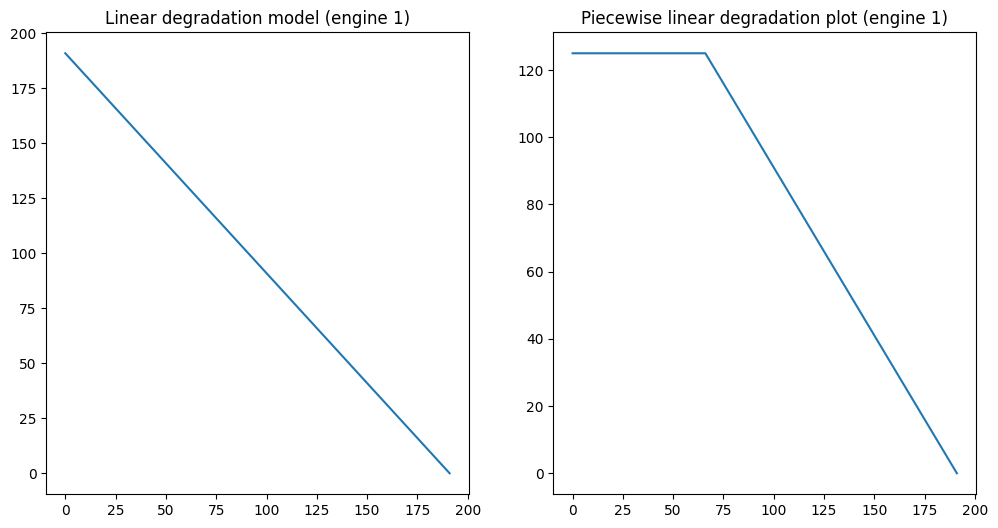

In [8]:
plt.figure(figsize = (12, 6))
plt.subplot(121)
plt.plot(engine_1_linear_degradation_model)
plt.title("Linear degradation model (engine 1)")
plt.subplot(122)
plt.plot(engine_1_piecewise_linear_degradation_model)
plt.title("Piecewise linear degradation plot (engine 1)")
plt.show()

Observe that while the linear degradation curve starts at 191 and ends at 0, piecewise linear degradation curve starts at 125, stays at 125 for some time and then linearly degrades to 0.

We can similarly find RUL values for other engines. But individually finding RUL for each engine is boring. So we will write a function that automatically finds RUL values for both models if it is supplied with the total number of cycles.

In [9]:
def process_targets(data_length, early_rul = None):
    """ 
    Takes datalength (i.e., total number of cycles for each engine) and early_rul as input and 
    creates target rul.
    
    Arguments:
        data_length: (scaler) Number of cycles for each engine
        early_rul: (scaler) Early RUL value to be set. When set to `None`, linear degradation
                   curve is used. (deafult: None)

    Returns:
        target_array: (1D float array) Target array
    """
    if early_rul == None:
        return np.arange(data_length-1, -1, -1)
    else:
        early_rul_duration = data_length - early_rul
        if early_rul_duration <= 0:    # This condition is needed when early rul is larger than data_length of an engine
            target_array = np.arange(data_length-1, -1, -1)
            return target_array
        else:
            target_array = np.append(early_rul*np.ones(shape = (early_rul_duration,)), np.arange(early_rul-1, -1, -1))
            return target_array

Now for any engine, we can find RUL values for both models. For example, we will take engine 7. From above we find that engine 7 fails after 259 cycles. So its data_length is 259.

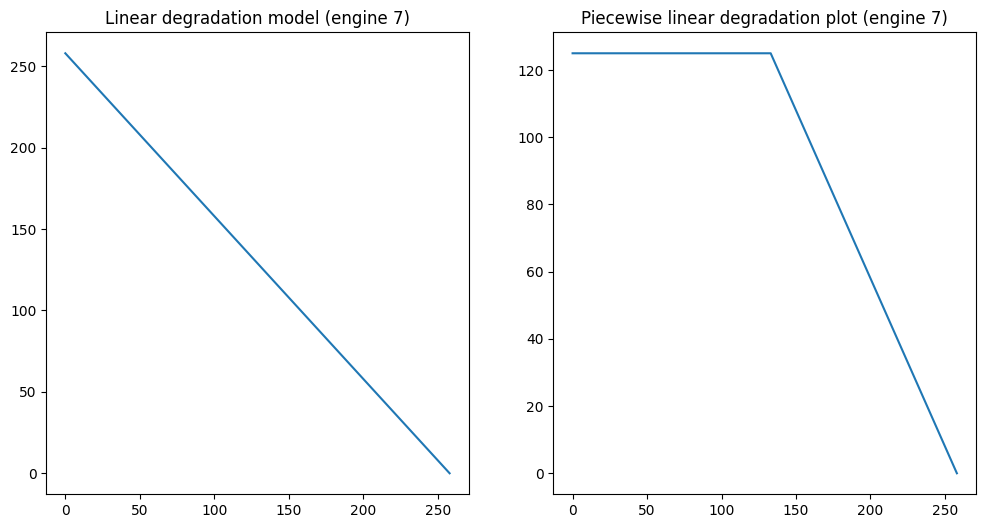

In [10]:
engine_7_linear_degradation_rul = process_targets(259, early_rul = None)
engine_7_piecewise_linear_degradation_rul = process_targets(259, early_rul = 125)
plt.figure(figsize = (12, 6))
plt.subplot(121)
plt.plot(engine_7_linear_degradation_rul)
plt.title("Linear degradation model (engine 7)")
plt.subplot(122)
plt.plot(engine_7_piecewise_linear_degradation_rul)
plt.title("Piecewise linear degradation plot (engine 7)")
plt.show()

### Analyzing Test data

Test data are similar to train data with only one difference. While for training data, data are available until failure for each engine, for test data, it is available for an arbitrary number of cycles. Using the given test data, out goal is to predict RUL. For test data, true RUL values are also available so that we can compare the performance of our prediction algorithm.

In [11]:
test_data = pd.read_csv("test_FD001.txt", sep = "\s+", header = None)
test_data.shape

(13096, 26)

In [12]:
test_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,21.61,553.90,2388.04,9050.17,1.3,47.20,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.3,47.50,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.3,47.50,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,21.61,554.07,2388.03,9045.29,1.3,47.28,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,21.61,554.16,2388.01,9044.55,1.3,47.31,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


### How many engines are there in test set?

In [13]:
np.unique(test_data[0])

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100], dtype=int64)

So there are 100 engines in test set also.

### How many cycles of data are available for each engine in test set?

In [14]:
test_data.groupby(0)[1].count().values

array([ 31,  49, 126, 106,  98, 105, 160, 166,  55, 192,  83, 217, 195,
        46,  76, 113, 165, 133, 135, 184, 148,  39, 130, 186,  48,  76,
       140, 158, 171, 143, 196, 145,  50, 203, 198, 126, 121, 125,  37,
       133, 123, 156, 172,  54, 152, 146,  73,  78, 303,  74, 144, 189,
       164, 121, 113, 136, 160, 176,  94, 147, 159, 232, 155, 168,  71,
       147,  71, 187,  54, 152,  68, 131, 112, 137,  88, 205, 162,  72,
       101, 133, 213, 162,  73, 172,  34, 110,  56,  68, 177, 146, 234,
       150, 244, 133,  89,  97, 134, 121,  97, 198], dtype=int64)

We can see that data for 31 cycles are available for engine 1 in test set. Data for 49 cycles are available for engine 2, and so on. Using the available data our goal is to predict RUL for each engine

In [15]:
true_rul = pd.read_csv('RUL_FD001.txt', sep = '\s+', header = None)
true_rul[0].values

array([112,  98,  69,  82,  91,  93,  91,  95, 111,  96,  97, 124,  95,
       107,  83,  84,  50,  28,  87,  16,  57, 111, 113,  20, 145, 119,
        66,  97,  90, 115,   8,  48, 106,   7,  11,  19,  21,  50, 142,
        28,  18,  10,  59, 109, 114,  47, 135,  92,  21,  79, 114,  29,
        26,  97, 137,  15, 103,  37, 114, 100,  21,  54,  72,  28, 128,
        14,  77,   8, 121,  94, 118,  50, 131, 126, 113,  10,  34, 107,
        63,  90,   8,   9, 137,  58, 118,  89, 116, 115, 136,  28,  38,
        20,  85,  55, 128, 137,  82,  59, 117,  20], dtype=int64)

An RUL value of 112 for engine 1 in test set means that it failed 112 cycles after 31st cycle. So engine 1 ran for (31+112) cycles before it failed. Similarly engine two failed 98 cycles after 49th cycle. So engine 2 ran for (49 + 98) cycles in total before it failed. Similar calculation can be done for other engines in test set.

For all our analysis, we will only use sensor measurements. First two columns of training data contain engine and cycle information respectively. So we don't need those columns while training an algorithm. Similarly columns 3-5 contain operational settings. We will also don't use those for training. It should be noted that some authors do use operational setting values to train their algorithm. But we will not do that. We will only use columns 6-26 values to train our algorithm as those are sensor measurements. But before we use those columns, we would first like to have some rough idea about the contents of the data. For that we will plot density plots of all sensor measurements of training data.

Boxplot of sensor measurements (columns 6-26)

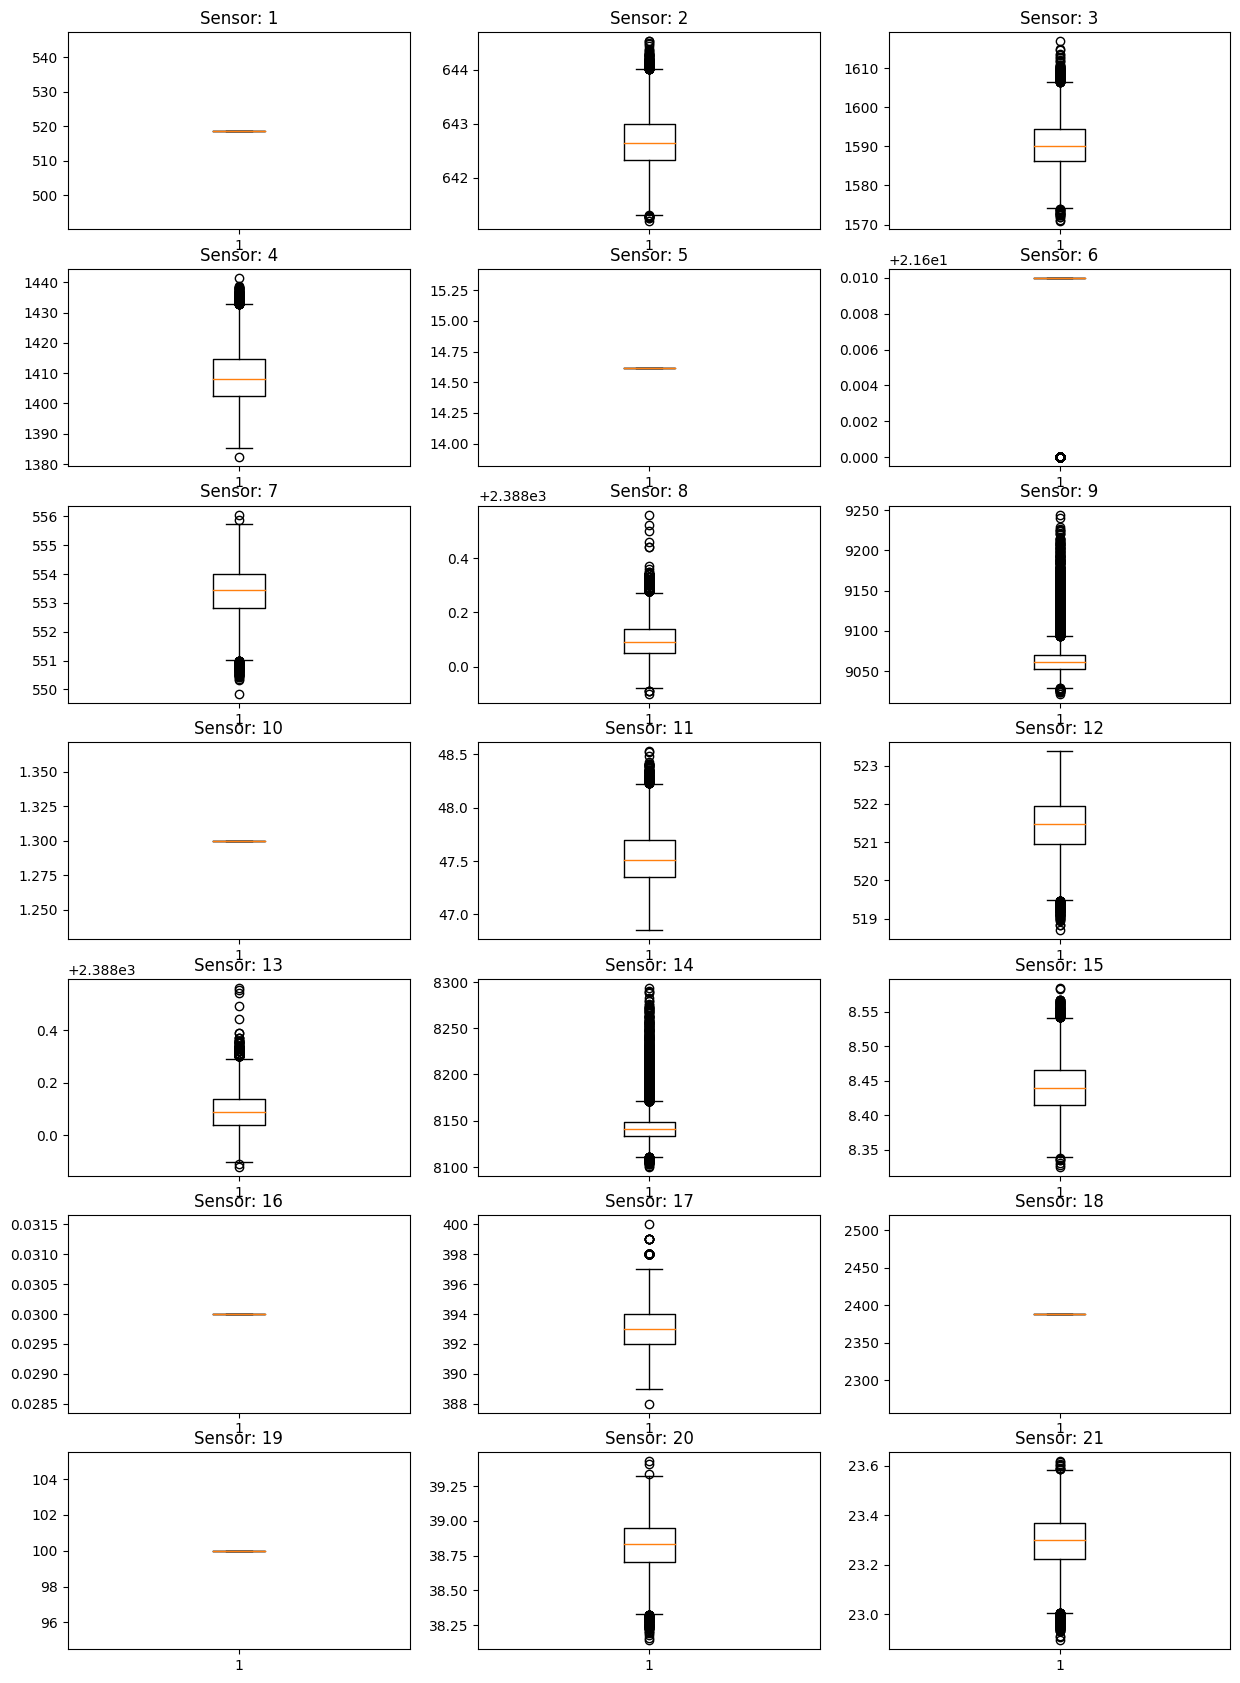

In [16]:
# box plots for sensor measurements (columns 5-25, total 21 columns)
plt.figure(figsize = (15, 21))
# column 5 in python means actual 6th column
for i in np.arange(5, 26):        
    temp = train_data.iloc[:, i]
    plt.subplot(7, 3, i-4)
    plt.boxplot(temp)
    plt.title("Sensor: "+ str(i-4))
plt.show()

From the above plot we see that columns 5, 9, 14, 20, 22, and 23 contain constant values. It also appears that Column 10 also contains only a few different values. We will check that. Constant values don't help us much while training an algorithm. Sometimes we also have to normalize data (subtract mean and divide by standard deviation). If a column contains a constant value, its standard deviation is zero. So normalization of that column is not possible as it requires division by zero. For these reasons, we will drop the columns containing constant values.

In [17]:
train_data[10].value_counts()

21.61    20225
21.60      406
Name: 10, dtype: int64

initial training data have a shape of 20631 by 26. We won't use engine info and operational settings for training. So after removing first 5 columns, our training data have a shape of 20631 by 21. From our previous data plotting, we found that 7 columns contain constant values. So ater removing those columns, our data have a shape of 20631 by 14.

We can plot density plot of other columns as follows.

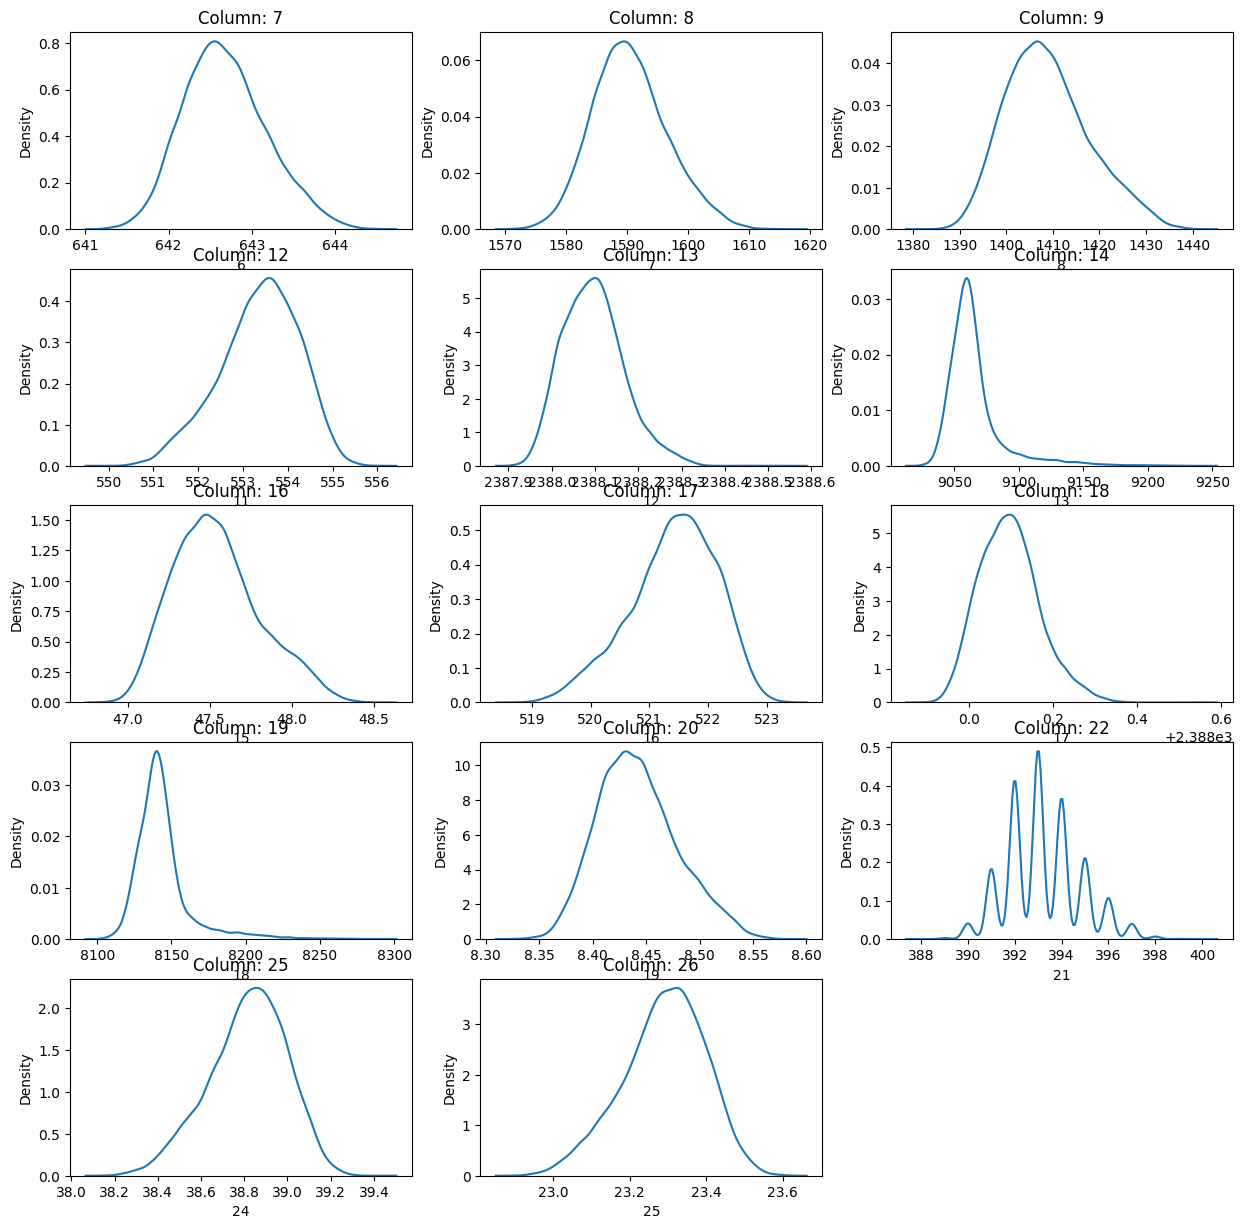

In [18]:
plt.figure(figsize = (15, 21))
for i,j in enumerate([6, 7, 8, 11, 12, 13, 15, 16, 17, 18, 19, 21, 24, 25]):
    temp = train_data.iloc[:, j]
    plt.subplot(7,3, i+1)
    sns.kdeplot(temp, legend = False)
    plt.title("Column: "+ str(j+1))
plt.show()

An algorithm generalizes well (i.e., its performance on unseen data is good) if unseen data is similar in distribution to training data. Unseen data need not be exactly of same distribution as of training data but it should not be very different from training data.

Here, we will just check the distribution of training and test data. It should be noted that test data should never be used while training an algorithm. Training an algorithm is an iterative process. With more parameters, it is very likely that training error reduces nearly zero. But its performance on new unseen data is not that good. In that case, we say that the model has overfit the training data (or memorized the training examples). Therefore, while training we have to devise some way to check whether the model is learning something or just memorizing the training data. To do that, we extract a portion of training data as validation set and use the validation set to check performance of trained model at each iteration. Once we are satisfied with the final model, we can use it to evaluate its performance on test data. While iterating over different models, we should avoid overfitting the validation data.

Here, we will only show the density plot of training as well as test data.

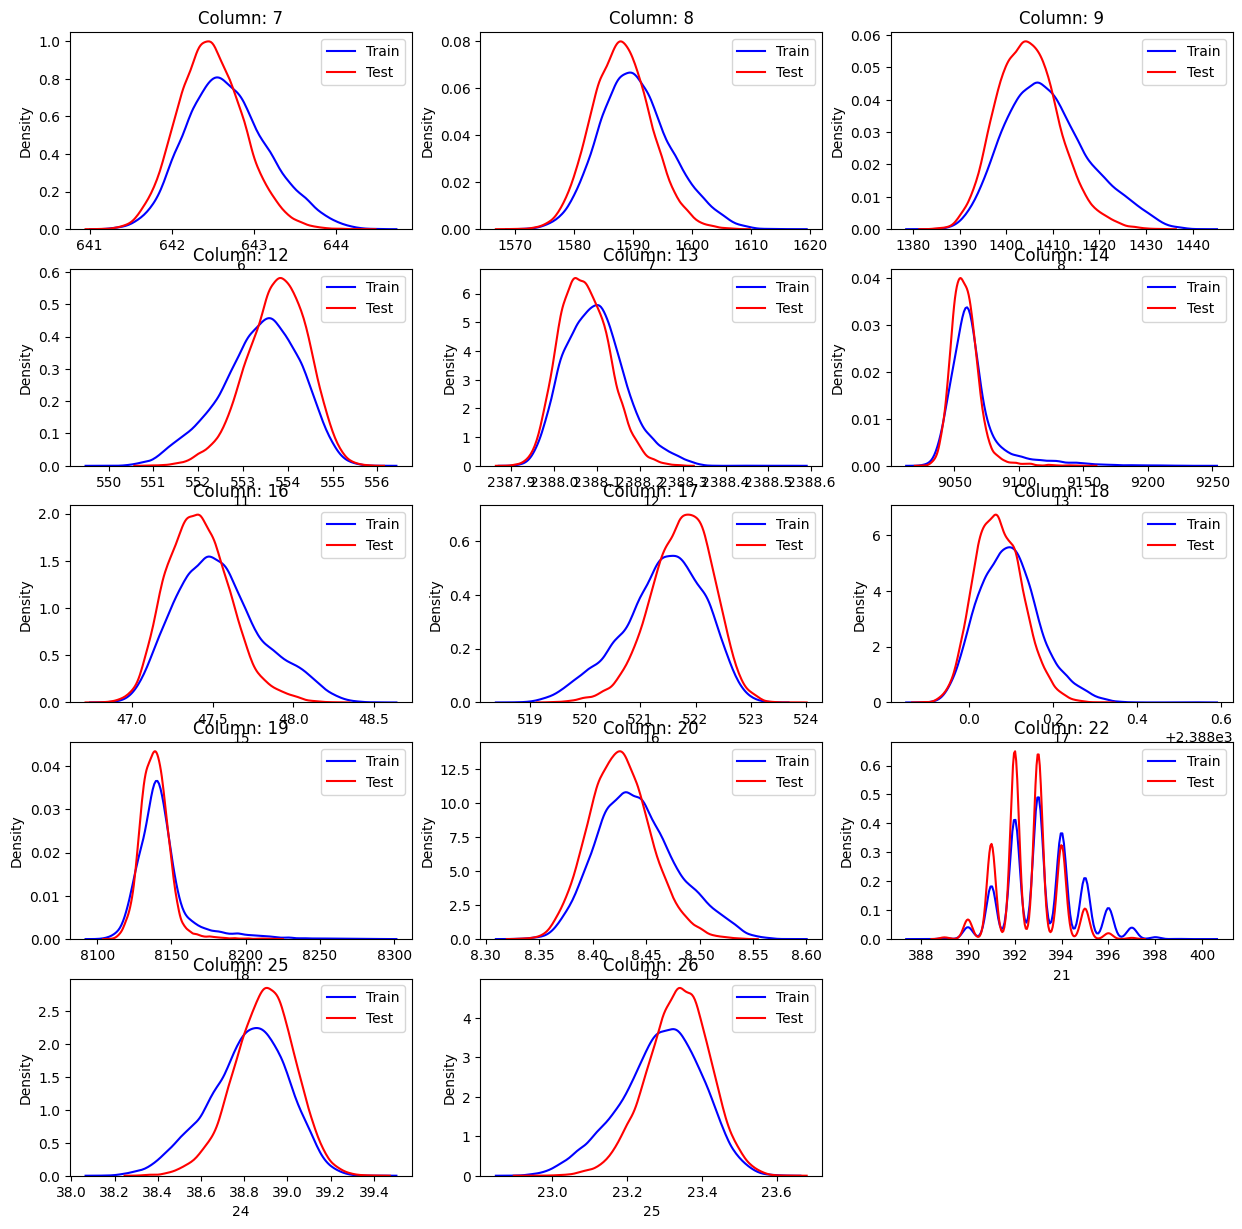

In [19]:
plt.figure(figsize = (15, 21))
for i,j in enumerate([6, 7, 8, 11, 12, 13, 15, 16, 17, 18, 19, 21, 24, 25]):
    temp_train = train_data.iloc[:, j]
    temp_test = test_data.iloc[:, j]
    plt.subplot(7,3, i+1)
    sns.kdeplot(temp_train, legend = False, color = "blue", label = "Train")
    sns.kdeplot(temp_test, legend = False, color = "red", label = "Test")
    plt.title("Column: "+ str(j+1))
    plt.legend()
plt.show()

Though not exact, test data has a similar distribution as training data. So if we design our algorithm carefully, it will generalize well.

### Preparing data for training algorithm

While preparing data for a training algorithm, we have to consider several factors. Some of the factors are listed below.

-Should data be scaled?
-If data are scaled, should a single scaling be applied to all engines or individual scaling be applied for every engine?
-Should linear degradation model or piecewise linear degradation model for RUL be used?
-If piecewise linear degradation model is used, what is the value of early RUL?

To make things more concrete, we will specify the shapes of array. Our initial training data have a shape of (20631 x 26) We won't use engine info and operational settings for training. So after removing first 5 columns, our training data have a shape of (20631 x 21) From our previous data plotting, we found that 7 columns contain constant values. So we remove those columns. After removing those columns, our data have a shape of (20631 x 14) We choose to apply scaling individually to every engine.

For some applications, we consider each row of the data matrix as a data point and our training model is trained accordingly. But for some other applications, we use a window of data. For example, if window length is, say, 20, size of data for training would be (20 x 14) There may be overlap between windows. The following figure illustrates it for a toy dataset with 6 rows and 4 columns.

Therefore, we will write a function, general enough, such that we can generate any type of data at a later stage depending upon our need. For that we need two custom functions: process targets and process_input_data_with_targets. We have already used the first function. Second function is defined as follows.

In [20]:
def process_input_data_with_targets(input_data, target_data = None, window_length = 1, shift = 1):
    """
    Depending on values of window_length and shift, this function generates batchs of data and targets 
    from `input_data` and `target_data`. `target_data` is optional. If no `target_data` is given, i.e., 
    `target_data = None`, no `output_targets` are generated. The following formula is used to determine
    number of batches. Please note that, here we use the term `batch` in a different sense than its usual
    meaning in deep learning.  
    
    Number of batches = int(np.floor((len(input_data) - window_length)/shift)) + 1
    
    **We don't check input dimensions using exception handling. So readers should be careful while using these
    functions. If input data are not of desired dimension, either error occurs or something undesirable is 
    produced as output.**
    
    Arguments:
        input_data: (Must be 2D array) input data to function 
        target_data (optional): (Must be 1D array) Input rul values (default: None)
        window_length: (scalar) window length of data (default: 1)
        shift: (scalar) Distance by which the window moves for next batch. This is closely related to overlap
               between data. For example, if window length is 30 and shift is 1, there is an overlap of 
               29 data points between two consecutive batches (default: 1)
        
    Returns:
        output_data: (2D float array) Output data that would be passed to machine learning model
        output_targets (optional): (1D float array) Output targets. Only generated if `target_data` is
                                   passed as argument.
    """
    num_batches = int(np.floor((len(input_data) - window_length)/shift)) + 1
    num_features = input_data.shape[1]
    output_data = np.repeat(np.nan, repeats = num_batches * window_length * num_features).reshape(num_batches, window_length,
                                                                                                  num_features)
    if target_data is None:
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
        return output_data
    else:
        output_targets = np.repeat(np.nan, repeats = num_batches)
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
            output_targets[batch] = target_data[(shift*batch + (window_length-1))]
        return output_data, output_targets

For each engine in the test set, we need to predict one RUL value. To predict one RUL value, we need one example of test data for each engine. So the obvious choice is to use the last example of test data for each engine. If an example consists of a window of data, for a given window length, we will take the last window of data that can be extracted from test set for a particular engine. For example, assume that for a particular engine, test set data has a shape of 45 by 14. For window_length = 30, and shift = 1, we can extract 16 windowed datasets of size 30 by 14. But we have to predict only one number as RUL for that engine. So, out of the 16 datasets of size , we will use the last one for predicting RUL. This approach, though technically correct, is prone to mistakes. What happens if the measurements of last example have some outliers? In that case our prediction would be way off. One approach to circumvent this issue is to take, say, last 5 examples instead of only the last example for each engine. Then we will get 5 RUL prediction values. We can average those to come up with our final estimate of RUL. In this way our RUL estimate will be a little conservative but robust against outliers in the last test example.

In [21]:
def process_test_data(test_data_for_an_engine, window_length, shift, num_test_windows = 1):
    """ 
    This function takes test data for an engine as first input. The next two inputs,
    window_length and shift are same as other functions. Finally it takes num_test_windows as
    the last input. num_test_windows sets how many examples we want from test data (from last).
    By default it extracts only the last example. The function returns last examples and number
    of last examples (a scaler) as output. We need the second output later. If we are extracting
    more than 1 last examples, we have to average their prediction results. The second scaler helps us do just that.
    Arguments:
        test_data_for_an_engine: (2D array) input test data
        window_length: (scalar) window length of data
        shift: (scalar) Distance by which the window moves for next batch. This is closely related to overlap
               between data. For example, if window length is 30 and shift is 1, there is an overlap of 
               29 data points between two consecutive batches.
        num_test_windows: (scalar) Number of examples to take from last. (default: 1)
    Returns:
        batched_test_data_for_an_engine: (2D array) Batched test data. Please note that, here we have used the term `batch`
                                         in a different sense than its usual meaning in deep learning.
        extracted_num_test_windows: (scalar) Extracted number of test examples from last. If `num_test_windows` number of
                                    examples can't be extracted from test data, in that case `extracted_num_test_windows`
                                    is less than `num_test_windows`. 
    """
    max_num_test_batches = int(np.floor((len(test_data_for_an_engine) - window_length)/shift)) + 1
    if max_num_test_batches < num_test_windows:
        required_len = (max_num_test_batches -1)* shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        extracted_num_test_windows = max_num_test_batches
        return batched_test_data_for_an_engine, extracted_num_test_windows
    else:
        required_len = (num_test_windows - 1) * shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        extracted_num_test_windows = num_test_windows
        return batched_test_data_for_an_engine, extracted_num_test_windows

In [22]:
window_length = 1
shift = 1
early_rul = 125             # Set to None for linear degradation model
processed_train_data = []
processed_train_targets = []
# How many test examples to take for each engine. If set to 1 (this is the default), only last example of test data for 
# each engine are taken. If set to a different number, that many examples from last are taken. 
# Final output for an engine will be the average of output of all examples for that engine.
num_test_windows = 5   # Number of examples. Choose a different number to select that many test examples for each engine.
processed_test_data = []
num_test_windows_list = []  # This list keeps track of number of examples for all engines in the test set.
columns_to_be_dropped = [0,1,2,3,4,5,9,10,14,20,22,23]
train_data_first_column = train_data[0]
test_data_first_column = test_data[0]
# Scale data for all engines
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data.drop(columns=columns_to_be_dropped))
test_data_scaled = scaler.transform(test_data.drop(columns=columns_to_be_dropped))
train_data_scaled = pd.DataFrame(data=np.c_[train_data_first_column, train_data_scaled])
test_data_scaled = pd.DataFrame(data=np.c_[test_data_first_column, test_data_scaled])
num_train_machines = len(train_data_scaled[0].unique())
num_test_machines = len(test_data_scaled[0].unique())
# Process training and test data sepeartely as number of engines in training and test set may be different.
# As we are doing scaling for full dataset, we are not bothered by different number of engines in training and test set.
# Process trianing data
for i in np.arange(1, num_train_machines + 1):
    temp_train_data = train_data[train_data[0] == i].drop(columns = [0]).values    
    # Verify if data of given window length can be extracted from training data
    if (len(temp_train_data) < window_length):
        print("Train engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")        
    temp_train_targets = process_targets(data_length = temp_train_data.shape[0], early_rul = early_rul)
    data_for_a_machine, targets_for_a_machine = process_input_data_with_targets(temp_train_data, temp_train_targets, 
                                                                                window_length = window_length, shift = shift)
    processed_train_data.append(data_for_a_machine)
    processed_train_targets.append(targets_for_a_machine)
processed_train_data = np.concatenate(processed_train_data)
processed_train_targets = np.concatenate(processed_train_targets)
# Process test data
for i in np.arange(1, num_test_machines + 1):
    temp_test_data = test_data[test_data[0] == i].drop(columns = [0]).values    
    # Verify if data of given window length can be extracted from test data
    if (len(temp_test_data) < window_length):
        print("Test engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")    
    # Prepare test data
    test_data_for_an_engine, num_windows = process_test_data(temp_test_data, window_length = window_length, shift = shift,
                                                             num_test_windows = num_test_windows)    
    processed_test_data.append(test_data_for_an_engine)
    num_test_windows_list.append(num_windows)
processed_test_data = np.concatenate(processed_test_data)
true_rul = true_rul[0].values
# Shuffle training data
index = np.random.permutation(len(processed_train_targets))
processed_train_data, processed_train_targets = processed_train_data[index], processed_train_targets[index]
print(processed_train_data.shape)
print(processed_train_targets.shape)
print(processed_test_data.shape)
print(true_rul.shape)

(20631, 1, 25)
(20631,)
(500, 1, 25)
(100,)


In [23]:
processed_train_data = processed_train_data.reshape(-1, processed_train_data.shape[2])
processed_test_data = processed_test_data.reshape(-1, processed_test_data.shape[2])
print("Processed train data shape: ", processed_train_data.shape)
print("Processed test data shape: ", processed_test_data.shape)

Processed train data shape:  (20631, 25)
Processed test data shape:  (500, 25)


We will first find best set of parameters using grid search and then use those parameters to make predictions. In grid search, we first define a grid of parameters. Then for each set of parameters, we will fit a 10 SVR models (as it is 10 fold cross validation). Finally we will average the result of all folds for a particular parameter choice. The parameter choice that gives best score for cross validation is chosen as the best hyperparameter. Grid search of hyperparameters (with cross validation) is computationally intensive. It might take a long time on a personal computer. If that is the case, readers are advised to comment the next cell and directly use the best hyperparameter values as done in subsequent cells.

## SVR model

We will first find best set of parameters using grid search and then use those parameters to make predictions. In grid search, we first define a grid of parameters. Then for each set of parameters, we will fit a 10 SVR models (as it is 10 fold cross validation). Finally we will average the result of all folds for a particular parameter choice. The parameter choice that gives best score for cross validation is chosen as the best hyperparameter.

Grid search of hyperparameters (with cross validation) is computationally intensive. It might take a long time on a personal computer. If that is the case, readers are advised to comment the next cell and directly use the best hyperparameter values as done in subsequent cells.

In [24]:
parameters = {"C":[50],
             'epsilon':[1],
             'kernel':["rbf"]}

In [25]:
tuned_svm_reg = GridSearchCV(SVR(),parameters,n_jobs = -1, cv= 10)

In [26]:
tuned_svm_reg.fit(processed_train_data, processed_train_targets)

GridSearchCV(cv=10, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [50], 'epsilon': [1], 'kernel': ['rbf']})

### Use the following best parameters if grid search takes a long time

Using the followoing parameters, define a new model, train it, and use the trained model to make predictions. We give an example as follows.
```
best_reg_model = SVR(kernel = "rbf", C = 100, epsilon = 5)
best_reg_model.fit(processed_train_data, processed_train_targets)
rul_pred_tuned = best_reg_model.predict(processed_test_data)
```

In [27]:
tuned_svm_reg.best_params_

{'C': 50, 'epsilon': 1, 'kernel': 'rbf'}

In [28]:
best_reg_model = tuned_svm_reg.best_estimator_
best_reg_model

SVR(C=50, epsilon=1)

We will use the best model to predict on test set.

In [30]:
rul_pred_tuned = best_reg_model.predict(processed_test_data)

preds_for_each_engine_tuned = np.split(rul_pred_tuned, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine_tuned = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows)) 
                                   for ruls_for_each_engine, num_windows in zip(preds_for_each_engine_tuned,
                                                                                num_test_windows_list)]
RMSE_tuned = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine_tuned))
MAE_tuned = mean_absolute_error(true_rul, mean_pred_for_each_engine_tuned)
print("RMSE after hyperparameter tuning: ", RMSE_tuned)
print("MAE after hyperparameter tuning: ", MAE_tuned)

RMSE after hyperparameter tuning:  34.87651069340861
MAE after hyperparameter tuning:  28.661349418614193


Note that while prediction, we are predicting RUL values for last 5 examples of every engine. Then we take mean of all 5 predictions for each engine and calculate final RMSE.

If instead we wish to take only the last example of every engine to make predictions and calculate RUL, we can do so by taking the last prediction of every engine as calculated before and calculate RMSE as follows.

In [31]:
indices_of_last_examples = np.cumsum(num_test_windows_list) - 1
preds_for_last_example = np.concatenate(preds_for_each_engine_tuned)[indices_of_last_examples]

RMSE_new = np.sqrt(mean_squared_error(true_rul, preds_for_last_example))
MAE_new = mean_absolute_error(true_rul, preds_for_last_example)
print("RMSE (Taking only last example): ", RMSE_new)
print("MAE (Taking only last example): ", MAE_new)

RMSE (Taking only last example):  34.659857473617855
MAE (Taking only last example):  28.430570117462363


If you are not convinced by above calculations, take a look at the last section of [this notebook](https://github.com/biswajitsahoo1111/rul_codes_open/blob/master/notebooks/cmapss_notebooks/CMAPSS_FD001_xgboost_piecewise_linear_degradation_model.ipynb).

For CMAPSS data, along with RMSE another metric (S-score) is usually reported in literature. S-score is defined as:

$$S= \sum_{i=1}^N{s_i}$$

where, 

$$
\begin{equation}
    s_i=
    \begin{cases}
      (e^{-\frac{d_i}{13}})-1, & \text{for}\ d_i < 1 \\
      (e^{\frac{d_i}{10}})-1, & \text{for}\ d_i \geq 1\\
    \end{cases}
  \end{equation}
  $$
  
We can compute the S-metric as follows.

In [32]:
def compute_s_score(rul_true, rul_pred):
    """
    Both rul_true and rul_pred should be 1D numpy arrays.
    """
    diff = rul_pred - rul_true
    return np.sum(np.where(diff < 0, np.exp(-diff/13)-1, np.exp(diff/10)-1))

In [33]:
s_score = compute_s_score(true_rul, preds_for_last_example)
print("S-score: ", s_score)

S-score:  10793.630590139805


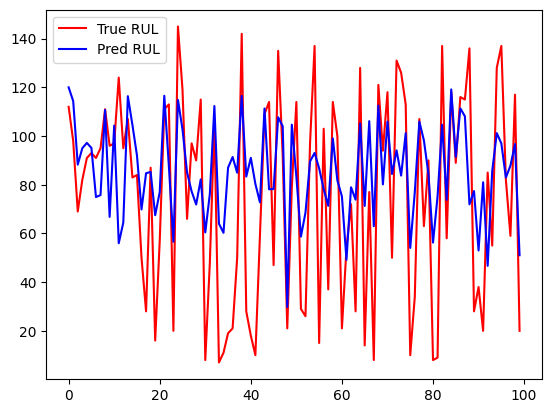

In [34]:
# Plot true and predicted RUL values
plt.plot(true_rul, label = "True RUL", color = "red")
plt.plot(preds_for_last_example, label = "Pred RUL", color = "blue")
plt.legend()
plt.show()

As a final note remember that hyperparameter tuning is more of an art than science. It is possible to obtain better results than what has been obtained here by choosing better set of hyperparameters.

For other reproducible results on RUL, interested readers can visit my [project page](https://biswajitsahoo1111.github.io/rul_codes_open). 